In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output

In [2]:
import re
prog = re.compile('[A-Za-z0-9]+')

path = 'aclImdb/train/unsup/'

def load_imdb_data(path, seq_len=40, gen=False):
    """
    Loads IMDB 50k unsupervised reviews
    
    path: str, path to the unsupervised reviews data
    seq_len: minimum length of sequence
    gen: if True all the reviews will be length of seq_len
    """
    reviews = []
    
    for i in tqdm(range(50000)):
        with open(path + f'{i}_0.txt', 'r') as f:
            rev = f.read()
        
        rev = rev.replace(' br ', ' ')
        if len(prog.findall(rev)) >= seq_len:
            if gen:
                reviews.append(['<sos>'] + prog.findall(rev)[:seq_len])
                if len(prog.findall(rev)[:seq_len]) == 39:
                    print(len(rev.split()))
            else:
                reviews.append(['<sos>'] + prog.findall(rev))
    return reviews

In [3]:
reviews = load_imdb_data(path, gen=False)

100%|██████████| 50000/50000 [00:06<00:00, 7967.19it/s]


In [4]:
reviews_40 = load_imdb_data(path, gen=True)

100%|██████████| 50000/50000 [00:07<00:00, 6421.87it/s]


In [5]:
def vocab_idxs(data):
    """
    Returns vocab, word2id and id2word, where
    vocab: set of all words in data
    word2id: dictionary that maps words on idxs
    id2word: inverse dictionary to word2id
    
    data: 
    type: list
    format: list of lists of words
    """
    vocab = set()
    for sentence in tqdm(data):
        for s in sentence:
            vocab.add(s)
    word2id = {k:v for v, k in enumerate(vocab, 1)}
    word2id['<m>'] = 0
    id2word = {v:k for k, v in word2id.items()}
    return vocab, word2id, id2word

In [6]:
vocab, word2id, id2word = vocab_idxs(reviews)

100%|██████████| 49668/49668 [00:01<00:00, 32466.96it/s]


In [7]:
def sents2matrix(data, word2id, seq_len=41):
    """
    Returns a matrix of integers
    where each row represents a sentence
    
    data:
    type: list
    format: list of lists of words of the seq_len length
    example: [['hello', 'world'], ['nice', 'day']]
    ----------------------------------------------------
    
    word2id: dict that maps word on idxs
    ----------------------------------------------------
    
    seq_len: len of lists contained in data
    """
    
    matrix = np.zeros((len(data), seq_len))
    for i in tqdm(range(len(data))):
        matrix[i] = np.array([int(word2id[word]) for word in data[i]])
    return np.array(matrix)

In [8]:
matrix = sents2matrix(reviews_40, word2id)

100%|██████████| 49668/49668 [00:00<00:00, 60799.38it/s]


In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.LongTensor(matrix))

# dataloaders
batch_size = 64

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [10]:
class PretrainedLSTM(nn.Module):
    
    def __init__(
        self, hidden_dim, vocab_size,
        embedding_dim, linear_dim=256, n_layers=3, device="cuda"
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.device = device
        
        # Embeddings
        self.embeddings = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
        
        # LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        
        # fully-connected layes
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, linear_dim),
            nn.ReLU(),
            nn.Linear(linear_dim, linear_dim),
            nn.ReLU(),
            nn.Linear(linear_dim, vocab_size)
        )
      
    
    def forward(self, x):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        
        x = self.embeddings(x)
        
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(self.device)
        
        output, hidden = self.lstm(x, (h0, c0))
        output = output.contiguous().view(-1, self.hidden_dim)
        output = self.fc(output)
        
        return output, hidden


In [11]:
hidden_dim = 256
embedding_dim = 110
vocab_size = len(vocab)

# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PretrainedLSTM(hidden_dim, vocab_size, embedding_dim, device=device)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def train_epoch(model, optimizer, train_loader, train_on_gpu=True):
    criterion = nn.CrossEntropyLoss()
    loss_log = []
    model.train()
    for sequence in train_loader:
        optimizer.zero_grad()
        X = sequence[0][:, :-1].to(model.device)
        y = sequence[0][:, 1:].to(model.device)
        output, hidden = model(X)
        loss = criterion(output, y.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    return loss_log   

def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs, train_loader, train_on_gpu=True):
    train_log = []
    total_steps = 0
    
    if train_on_gpu:
        model.cuda()
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_loader)
        train_log.extend(train_loss)
        total_steps += len(train_loader)
        
        train_log.extend(train_loss)
        
        clear_output()
        plot_history(train_log)

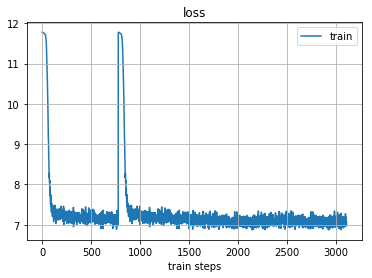

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, opt, 20, train_loader)

In [ ]:
torch.save(model.state_dict(), 'model.ckpt')